In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import scipy.special as sps
import scipy.stats as stats
import matplotlib.pyplot as plt

In [165]:
G = np.array([[1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
              [1, 0, 1, 1, 1, 0, 1, 0, 1, 1],
              [0, 1, 1, 0, 1, 1, 1, 0, 0, 1],
              [0, 1, 0, 0, 0, 0, 1, 1, 1, 1]])

In [3]:
G.shape

(4, 10)

In [206]:
def gen_all_binaries_constrained_by_1_num(n, d):
    if n == 0:
        yield np.array([], dtype=int)
    elif d == 0:
        yield np.zeros((n,))
    else:
        for sub in gen_all_binaries_constrained_by_1_num(n - 1, d):
            yield np.concatenate((np.array([0]), sub))
        for sub in gen_all_binaries_constrained_by_1_num(n - 1, d - 1):
            yield np.concatenate((np.array([1]), sub))
            
def gen_all_binaries(n):
    return gen_all_binaries_constrained_by_1_num(n, n)

In [5]:
def triangle(A):
    (k, n) = A.shape
    A = A.copy()
    for i in range(0, k):
        # beginning of span
        b = i
        maxindex = A[i:,b].argmax() + i
        while A[maxindex, b] == 0 and b < n:
            b += 1
            maxindex = A[i:,b].argmax() + i
        if maxindex != i:
            A[[i, maxindex]] = A[[maxindex, i]]
        
        for j in range(i+1, k):
            if A[j, b] > 0:
                A[j] = (A[i] + A[j]) % 2
    return A

def end(s):
    return max(s * np.arange(0, len(s)))

def MSF(A):
    At = triangle(A)
    (k, n) = At.shape
    
    for i in range(0, k):
        e = end(At[i])
        has_same_ends = True
        while has_same_ends:
            has_same_ends = False
            for j in range(i+1, k):
                e2 = end(At[j])
                if e2 == e:
                    has_same_ends = True
                    At[i] = (At[i] + At[j]) % 2
                    e = end(At[i])
    return At
        

In [6]:
MSF(G)

array([[1, 1, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 0, 1, 1, 1, 0, 0, 1],
       [0, 0, 1, 1, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 0, 1, 0, 1, 0]])

In [111]:
def mk_row(active, state, k):
    row = np.zeros(k)
    j = 0
    for i in active:
        row[i] = state[j]
        j += 1
    return row

def arr_to_str(A):
    return ''.join(map(lambda x: str(int(x)), A))

def str_to_arr(s):
    return list(map(int, s))

def MSF_lattice(A):
    A = MSF(A)
    active = set()
    active_sets = [set()]
    next_active = 0
    lattice = [{"": {}}]
    (k, n) = A.shape
    for i in range(0, n):
        while next_active < k and A[next_active, i] > 0:
            active.add(next_active)
            next_active += 1
        for j in list(active):
            if end(A[j]) <= i:
                active.remove(j)
        active_sets.append(active.copy())
        lattice.append({})
        cur_col = A[:, i]
        for s_state in lattice[i]:
            state = np.array(str_to_arr(s_state), dtype=int)
            st_row = mk_row(active_sets[i], state, k)
            cur_res = int(np.dot(cur_col, st_row)) % 2
            new_actives = list(active_sets[i+1] - active_sets[i])
            min_cur_active = min(active_sets[i]) if len(active_sets[i]) > 0 else 0
            inters = list(map(lambda x: x - min_cur_active,
                              active_sets[i].intersection(active_sets[i+1])))
            inters_state = list(state[inters])
            if len(new_actives) == 1:
                for cur_c in [0, 1]:
                    new_act = (cur_res + cur_c) % 2
                    new_state = inters_state + [new_act]
                    new_s_state = arr_to_str(new_state)
                    lattice[i][s_state][cur_c] = new_s_state
                    if new_s_state not in lattice[i+1]:
                        lattice[i+1][new_s_state] = {}
            elif len(new_actives) == 0:
                inters_s_state = arr_to_str(inters_state)
                lattice[i][s_state][cur_res] = inters_s_state
                if inters_s_state not in lattice[i+1]:
                    lattice[i+1][inters_s_state] = {}
            else:
                raise Exception("oy wey something's bad")
    return lattice, active_sets
        

In [112]:
def syndrom_lattice(H):
    (k, n) = H.shape
    init_syndrom = np.zeros(k, dtype=int)
    init_layer = {}
    init_layer[arr_to_str(init_syndrom)] = {}
    lattice = [init_layer]
    for i in range(0, n):
        lattice.append({})
        cur_col = H[:, i]
        for s_state in lattice[i]:
            syndrom = np.array(str_to_arr(s_state))
            for cur_c in [0, 1]:
                nxt_syndrom = (syndrom + cur_c * cur_col) % 2
                nxt_s = arr_to_str(nxt_syndrom)
                lattice[i][s_state][cur_c] = nxt_s
                if nxt_s not in lattice[i+1]:
                    lattice[i+1][nxt_s] = {}
    # pruning
    lattice[n] = {}
    lattice[n][arr_to_str(np.zeros(k, dtype=int))] = {}
    for i in range(1, n):
        j = n - i
        for state in list(lattice[j].keys()):
            for cur_c in [0, 1]:
                if lattice[j][state][cur_c] not in lattice[j + 1]:
                    del lattice[j][state][cur_c]
            if len(lattice[j][state]) == 0:
                del lattice[j][state]
    return lattice

In [152]:
def lattice_to_dot(lattice, actives=None):
    print("graph lattice {")
    print("rankdir=\"LR\"")
    print("node [shape=\"circle\"]")
        
    if actives is not None:
        for (i, act_set) in enumerate(actives):
            s = ','.join(map(lambda j: 'm<SUB>{}</SUB>'.format(j), act_set))
            s = '<'+s+'>' if len(s) > 0 else '""'
            print("m{} [label={}, shape=\"plaintext\"]".format(i, s))
        for i in range(0, len(actives)-1):
            print("m{} -- m{} [style=invis]".format(i, i+1))
        
    for (i, layer) in enumerate(lattice):
        print("subgraph layer_{} {{".format(i))
        keys = sorted(layer.keys())
        for s in keys:
            print("a{}_{} [label=\"{}\"];".format(i, s, s))
        print("}")
    for (i, layer) in enumerate(lattice):
        for (s, links) in layer.items():
            for (c, s1) in links.items():
                print("a{}_{} -- a{}_{} [label=\"{}\"];".format(i, s, i+1, s1, c))
    print("}")

In [146]:
lat, acts = MSF_lattice(G)
lattice_to_dot(lat, acts)

graph lattice {
rankdir="LR"
node [shape="circle"]
m0 [label="", shape="plaintext"]
m1 [label=<m<SUB>0</SUB>>, shape="plaintext"]
m2 [label=<m<SUB>0</SUB>,m<SUB>1</SUB>>, shape="plaintext"]
m3 [label=<m<SUB>0</SUB>,m<SUB>1</SUB>,m<SUB>2</SUB>>, shape="plaintext"]
m4 [label=<m<SUB>0</SUB>,m<SUB>1</SUB>,m<SUB>2</SUB>,m<SUB>3</SUB>>, shape="plaintext"]
m5 [label=<m<SUB>0</SUB>,m<SUB>1</SUB>,m<SUB>2</SUB>,m<SUB>3</SUB>>, shape="plaintext"]
m6 [label=<m<SUB>0</SUB>,m<SUB>1</SUB>,m<SUB>2</SUB>,m<SUB>3</SUB>>, shape="plaintext"]
m7 [label=<m<SUB>1</SUB>,m<SUB>2</SUB>,m<SUB>3</SUB>>, shape="plaintext"]
m8 [label=<m<SUB>1</SUB>,m<SUB>3</SUB>>, shape="plaintext"]
m9 [label=<m<SUB>1</SUB>>, shape="plaintext"]
m10 [label="", shape="plaintext"]
m0 -- m1 [style=invis]
m1 -- m2 [style=invis]
m2 -- m3 [style=invis]
m3 -- m4 [style=invis]
m4 -- m5 [style=invis]
m5 -- m6 [style=invis]
m6 -- m7 [style=invis]
m7 -- m8 [style=invis]
m8 -- m9 [style=invis]
m9 -- m10 [style=invis]
}
subgraph layer_0 {
a0_ [l

In [147]:
lattice_to_dot(syndrom_lattice(G))

graph lattice {
rankdir="LR"
node [shape="circle"]
subgraph layer_0 {
a0_0000 [label="0000"];
}
subgraph layer_1 {
a1_0000 [label="0000"];
a1_1100 [label="1100"];
}
subgraph layer_2 {
a2_0000 [label="0000"];
a2_0011 [label="0011"];
a2_1100 [label="1100"];
a2_1111 [label="1111"];
}
subgraph layer_3 {
a3_0000 [label="0000"];
a3_0001 [label="0001"];
a3_0010 [label="0010"];
a3_0011 [label="0011"];
a3_1100 [label="1100"];
a3_1101 [label="1101"];
a3_1110 [label="1110"];
a3_1111 [label="1111"];
}
subgraph layer_4 {
a4_0000 [label="0000"];
a4_0001 [label="0001"];
a4_0010 [label="0010"];
a4_0011 [label="0011"];
a4_0100 [label="0100"];
a4_0101 [label="0101"];
a4_0110 [label="0110"];
a4_0111 [label="0111"];
a4_1000 [label="1000"];
a4_1001 [label="1001"];
a4_1010 [label="1010"];
a4_1011 [label="1011"];
a4_1100 [label="1100"];
a4_1101 [label="1101"];
a4_1110 [label="1110"];
a4_1111 [label="1111"];
}
subgraph layer_5 {
a5_0000 [label="0000"];
a5_0001 [label="0001"];
a5_0010 [label="0010"];
a5_0011 [

In [149]:
misha_G = np.array([ [1, 1, 1, 0]
    , [1, 1, 1, 1]
    , [1, 0, 0, 1]
    , [0, 1, 1, 1]
    , [1, 1, 0, 1]
    , [1, 0, 1, 0]
    , [1, 0, 0, 0]
    , [0, 1, 0, 0]
    , [0, 0, 1, 0]
    , [0, 0, 0, 1]
    ]).transpose()

In [153]:
m_lat, m_acts = MSF_lattice(misha_G)
lattice_to_dot(m_lat, m_acts)

graph lattice {
rankdir="LR"
node [shape="circle"]
m0 [label="", shape="plaintext"]
m1 [label=<m<SUB>0</SUB>>, shape="plaintext"]
m2 [label=<m<SUB>0</SUB>,m<SUB>1</SUB>>, shape="plaintext"]
m3 [label=<m<SUB>0</SUB>,m<SUB>1</SUB>,m<SUB>2</SUB>>, shape="plaintext"]
m4 [label=<m<SUB>0</SUB>,m<SUB>1</SUB>,m<SUB>2</SUB>>, shape="plaintext"]
m5 [label=<m<SUB>0</SUB>,m<SUB>1</SUB>,m<SUB>2</SUB>,m<SUB>3</SUB>>, shape="plaintext"]
m6 [label=<m<SUB>0</SUB>,m<SUB>1</SUB>,m<SUB>2</SUB>,m<SUB>3</SUB>>, shape="plaintext"]
m7 [label=<m<SUB>1</SUB>,m<SUB>2</SUB>,m<SUB>3</SUB>>, shape="plaintext"]
m8 [label=<m<SUB>1</SUB>,m<SUB>3</SUB>>, shape="plaintext"]
m9 [label=<m<SUB>1</SUB>>, shape="plaintext"]
m10 [label="", shape="plaintext"]
m0 -- m1 [style=invis]
m1 -- m2 [style=invis]
m2 -- m3 [style=invis]
m3 -- m4 [style=invis]
m4 -- m5 [style=invis]
m5 -- m6 [style=invis]
m6 -- m7 [style=invis]
m7 -- m8 [style=invis]
m8 -- m9 [style=invis]
m9 -- m10 [style=invis]
subgraph layer_0 {
a0_ [label=""];
}
subg

In [151]:
lattice_to_dot(syndrom_lattice(misha_G))

graph lattice {
rankdir="LR"
node [shape="circle"]
subgraph layer_0 {
a0_0000 [label="0000"];
}
subgraph layer_1 {
a1_0000 [label="0000"];
a1_1110 [label="1110"];
}
subgraph layer_2 {
a2_0000 [label="0000"];
a2_0001 [label="0001"];
a2_1110 [label="1110"];
a2_1111 [label="1111"];
}
subgraph layer_3 {
a3_0000 [label="0000"];
a3_0001 [label="0001"];
a3_0110 [label="0110"];
a3_0111 [label="0111"];
a3_1000 [label="1000"];
a3_1001 [label="1001"];
a3_1110 [label="1110"];
a3_1111 [label="1111"];
}
subgraph layer_4 {
a4_0000 [label="0000"];
a4_0001 [label="0001"];
a4_0110 [label="0110"];
a4_0111 [label="0111"];
a4_1000 [label="1000"];
a4_1001 [label="1001"];
a4_1110 [label="1110"];
a4_1111 [label="1111"];
}
subgraph layer_5 {
a5_0000 [label="0000"];
a5_0001 [label="0001"];
a5_0010 [label="0010"];
a5_0011 [label="0011"];
a5_0100 [label="0100"];
a5_0101 [label="0101"];
a5_0110 [label="0110"];
a5_0111 [label="0111"];
a5_1000 [label="1000"];
a5_1001 [label="1001"];
a5_1010 [label="1010"];
a5_1011 [

In [12]:
p1 = 0.0011099
p2 = 0.0899001
p3 = 0.0099889
p4 = 0.8091010

In [304]:
# 4.2
def DSK_epsilon(e0, n0):
    return 1 - stats.norm.cdf(np.sqrt(2*e0/n0))

def DSK_prob_gen(eps):
    def p(x, c):
        neq = np.abs(x - c)
        return eps * neq + (1 - eps) * (1 - neq)
    return p
    
def DSK_likelihood_gen(eps):
    p = DSK_prob_gen(eps)
    def L(y):
        return np.log(p(y, 1) / p(y, 0))
    return L

def AWGN_likelihood(y):
    return y

def ML_dot(c, y, L):
    return np.dot(2*c-1, L(y))

def decode_ML(y, cs, L):
    lms = list(map(lambda c: ML_dot(c, y, L), cs))
    return cs[np.argmax(lms)]

def decode_ML_DSK(y, cs, e0, n0):
    eps = DSK_epsilon(e0, n0)
    L = DSK_likelihood_gen(eps)
    return decode_ML(y, cs, L)

def decode_ML_AWGN(y, cs, e0, n0):
    return decode_ML(y, cs, AWGN_likelihood)

def channel_AWGN(c, e0, n0):
    return (2*c - 1)*stats.norm.rvs(loc=np.sqrt(e0), scale=np.sqrt(n0), size=len(c))

def channel_DSK(c, e0, n0):
    return np.array(channel_AWGN(c, e0, n0) > 0, dtype=int)

In [262]:
def db_to_unit(db):
    return 10**(db / 10)

def unit_to_db(unit):
    return 10*np.log10(unit)

In [263]:
const_e0 = 5
db_points = np.array([-2, -1, 0, 1, 2, 3, 4, 4.5, 5, 5.5, 6, 6.25, 6.5, 6.75, 7, 7.25, 7.5, 7.75,
                      8, 8.25, 8.5, 8.75, 9, 9.25, 9.5, 9.75, 10])
unit_points = db_to_unit(db_points)
n0_points = const_e0 / unit_points

In [313]:
def gen_all_words(G):
    (k, n) = G.shape
    for b in gen_all_binaries(k):
        yield np.dot(b, G) % 2

G_words = list(gen_all_words(G))

In [314]:
def model_err_prob(e0, n0, words, channel_f, decode_f, err_prob=1e-5, epochs=10):
    n = len(words[0])
    print(unit_to_db(e0/n0))
    min_tries = int(1 / err_prob / n)
    tries = epochs * min_tries
    total_bits = tries * n
    err_bits = 0
    j = 0
    print(tries)
    for i in np.random.randint(0, len(words), tries):
        j += 1
        word = words[i]
        y = channel_f(word, e0, n0)
        c = decode_f(y, words, e0, n0)
        if j % (tries / 10) == 0:
            print("step " + str(j))
            print(word, y, c)
        err_bits += np.sum(c != y)
    return err_bits / total_bits

In [311]:
%%time
model_err_prob(const_e0, n0_points[0], G_words, channel_DSK, decode_ML_DSK)

-2.0
99990
step 9999
[1 1 1 0 0 0 1 1 1 0] [1 1 0 1 0 0 1 1 0 0] [1 1 1 1 1 0 0 1 0 0]
step 19998
[1 0 1 0 0 0 0 0 0 1] [1 0 0 0 0 0 0 0 1 0] [0 0 0 0 0 0 0 0 0 0]
step 29997
[0 0 1 0 1 1 0 1 1 0] [0 1 1 1 1 1 1 1 1 0] [0 0 1 0 1 1 0 1 1 0]
step 39996
[1 1 1 0 0 0 1 1 1 0] [0 1 1 0 0 0 1 1 0 1] [0 1 0 0 0 0 1 1 1 1]
step 49995
[1 0 1 1 1 0 1 0 1 1] [1 0 1 0 1 0 0 0 1 1] [1 0 1 1 1 0 1 0 1 1]
step 59994
[1 1 0 1 0 1 0 0 1 0] [0 1 0 1 0 1 0 0 1 1] [0 1 1 1 0 1 0 0 1 1]
step 69993
[1 1 1 1 1 0 0 1 0 0] [0 0 0 0 1 0 1 0 1 0] [0 0 0 1 1 0 1 0 1 0]
step 79992
[1 1 1 1 1 0 0 1 0 0] [1 1 1 1 1 0 0 0 1 0] [1 1 1 1 1 0 0 1 0 0]
step 89991
[0 0 1 0 1 1 0 1 1 0] [0 0 0 0 0 1 1 1 0 0] [0 0 1 1 0 1 1 1 0 0]
step 99990
[0 1 1 1 0 1 0 0 1 1] [0 0 0 1 0 1 0 0 1 1] [0 1 1 1 0 1 0 0 1 1]
CPU times: user 56.1 s, sys: 94 ms, total: 56.2 s
Wall time: 56.1 s


0.16225822582258226

In [397]:
data_points = [("DSC, ML",[(-2.0,-1.156930502454862),(-1.0,-1.373294280823409),(0.0,-1.6361812624358223),(1.0,-1.9679536924845866),(2.0,-2.3647978316114124),(3.0,-2.870632404277014),(4.0,-3.4087127349415005),(4.6,-3.868381335650874),(4.8,-3.9888526392242025),(5.0,-4.131943638176958),(5.2,-4.287350298372788),(5.4,-4.376750709602099),(5.6000000000000005,-4.5951662833800615),(5.800000000000001,-4.76447155309245),(6.000000000000001,-4.913640169325251),(6.200000000000001,-5.07469413473523),(6.400000000000001,-5.236572006437062),(6.600000000000001,-5.356547323513812),(6.800000000000002,-5.585026652029181),(7.000000000000002,-6.221848749616355),(7.200000000000002,-6.096910013008056),(7.400000000000002,None),(7.600000000000002,None),(7.8000000000000025,None),(8.000000000000004,None),(8.200000000000005,None),(8.400000000000006,None)]),
("DSC, MAP",[(-2.0,-1.1571799042068631),(-1.0,-1.373294280823409),(0.0,-1.6361812624358223),(1.0,-1.9680182415948815),(2.0,-2.364677132787558),(3.0,-2.8710194760333883),(4.0,-3.406492410668234),(4.6,-3.868381335650874),(4.8,-3.9888526392242025),(5.0,-4.134303940083929),(5.2,-4.287350298372788),(5.4,-4.376750709602099),(5.6000000000000005,-4.5951662833800615),(5.800000000000001,-4.76447155309245),(6.000000000000001,-4.913640169325251),(6.200000000000001,-4.97469413473523),(6.400000000000001,-5.266572006437062),(6.600000000000001,-5.356547323513812),(6.800000000000002,-5.585016652029181),(7.000000000000002,-6.221848749616355),(7.200000000000002,-6.096910013008056),(7.400000000000002,None),(7.600000000000002,None),(7.8000000000000025,None),(8.000000000000004,None),(8.200000000000005,None),(8.400000000000006,None)]),
("AWGN, ML",[(-2.0,-0.6354152379212864),(-1.0,-0.8096823115550892),(0.0,-1.0988229440078638),(1.0,-1.5584619612978392),(2.0,-2.2674936599044613),(3.0,-3.3222106089311385),(4.0,-4.8124792791635365),(4.1,-4.991399828238082),(4.2,-5.154901959985742),(4.300000000000001,-5.352841968657781),(4.400000000000001,-5.469788758288393),(4.500000000000002,-5.582878745280337),(4.600000000000002,-5.7447274948966935),(4.700000000000003,-6.221848749616355),(4.800000000000003,None),(4.900000000000004,-6.221848749616355)]),
("AWGN, MAP",[(-2.0,-0.6354152379212864),(-1.0,-0.8096823115550892),(0.0,-1.0988229440078638),(1.0,-1.5584619612978392),(2.0,-2.2674936599044613),(3.0,-3.3222106089311385),(4.0,-4.8124792791635365),(4.1,-4.991399828238082),(4.2,-5.154901959985742),(4.300000000000001,-5.552841968657781),(4.400000000000001,-5.619788758288393),(4.500000000000002,-5.522878745280337),(4.600000000000002,-5.7447274948966935),(4.700000000000003,-6.221848749616355),(4.800000000000003,None),(4.900000000000004,-6.221848749616355)])
]

In [398]:
data_points_filtered = list(map(lambda pls: (pls[0], list(filter(lambda xy: xy[1] is not None, pls[1]))), data_points))

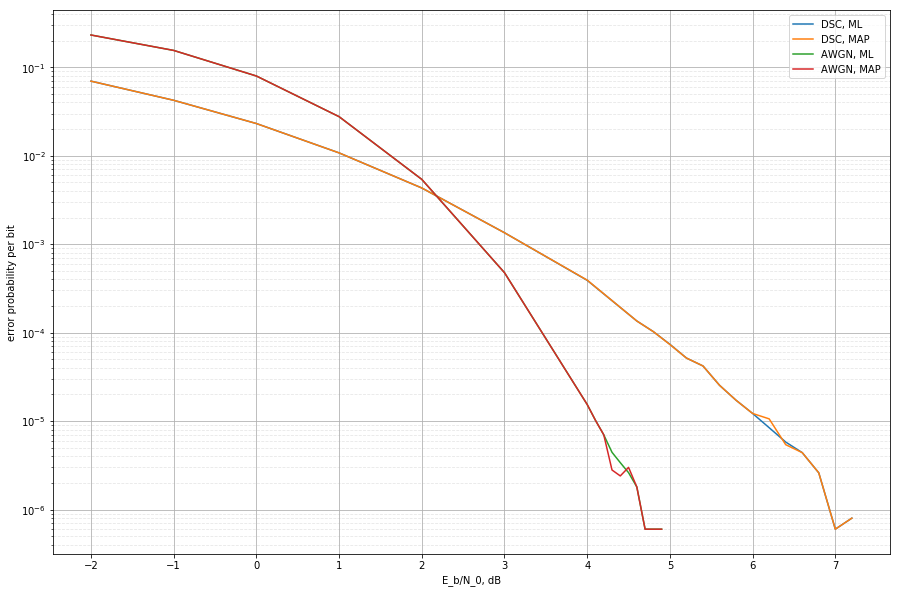

In [399]:
fig = plt.figure(figsize=(15,10))
plt.xlabel("E_b/N_0, dB")
plt.ylabel("error probability per bit")
plt.yscale('log')
plt.xticks(np.arange(-2, 8, 1))
plt.grid(b=True, which='major')
plt.grid(b=True, which='minor', alpha=0.3, linestyle='--')
for (label, data) in data_points_filtered:
    [xs, ys] = [list(t) for t in zip(*data)]
    plt.plot(xs, list(map(lambda y: 10**y, ys)), label=label)
plt.legend()
plt.show()

In [332]:
db_to_unit(5)

3.1622776601683795

In [334]:
H = np.array([[1,0,0],[1,0,1],[0,1,0],[0,0,1],[1,1,0],[1,1,1]]).transpose()
lattice_to_dot(syndrom_lattice(H))

graph lattice {
rankdir="LR"
node [shape="circle"]
subgraph layer_0 {
a0_000 [label="000"];
}
subgraph layer_1 {
a1_000 [label="000"];
a1_100 [label="100"];
}
subgraph layer_2 {
a2_000 [label="000"];
a2_001 [label="001"];
a2_100 [label="100"];
a2_101 [label="101"];
}
subgraph layer_3 {
a3_000 [label="000"];
a3_001 [label="001"];
a3_110 [label="110"];
a3_111 [label="111"];
}
subgraph layer_4 {
a4_000 [label="000"];
a4_001 [label="001"];
a4_110 [label="110"];
a4_111 [label="111"];
}
subgraph layer_5 {
a5_000 [label="000"];
a5_111 [label="111"];
}
subgraph layer_6 {
a6_000 [label="000"];
}
a0_000 -- a1_000 [label="0"];
a0_000 -- a1_100 [label="1"];
a1_100 -- a2_100 [label="0"];
a1_100 -- a2_001 [label="1"];
a1_000 -- a2_000 [label="0"];
a1_000 -- a2_101 [label="1"];
a2_100 -- a3_110 [label="1"];
a2_101 -- a3_111 [label="1"];
a2_001 -- a3_001 [label="0"];
a2_000 -- a3_000 [label="0"];
a3_111 -- a4_111 [label="0"];
a3_111 -- a4_110 [label="1"];
a3_001 -- a4_001 [label="0"];
a3_001 -- a4_000

In [337]:
G = np.array([[1, 0, 1, 1, 0, 1],
              [1, 0, 1, 0, 1, 0],
              [1, 1, 0, 1, 0, 0]])
lt, acts = MSF_lattice(G)
lattice_to_dot(lt, acts)

graph lattice {
rankdir="LR"
node [shape="circle"]
m0 [label="", shape="plaintext"]
m1 [label=<m<SUB>0</SUB>>, shape="plaintext"]
m2 [label=<m<SUB>0</SUB>,m<SUB>1</SUB>>, shape="plaintext"]
m3 [label=<m<SUB>0</SUB>,m<SUB>1</SUB>>, shape="plaintext"]
m4 [label=<m<SUB>1</SUB>,m<SUB>2</SUB>>, shape="plaintext"]
m5 [label=<m<SUB>2</SUB>>, shape="plaintext"]
m6 [label="", shape="plaintext"]
m0 -- m1 [style=invis]
m1 -- m2 [style=invis]
m2 -- m3 [style=invis]
m3 -- m4 [style=invis]
m4 -- m5 [style=invis]
m5 -- m6 [style=invis]
subgraph layer_0 {
a0_ [label=""];
}
subgraph layer_1 {
a1_0 [label="0"];
a1_1 [label="1"];
}
subgraph layer_2 {
a2_00 [label="00"];
a2_01 [label="01"];
a2_10 [label="10"];
a2_11 [label="11"];
}
subgraph layer_3 {
a3_00 [label="00"];
a3_01 [label="01"];
a3_10 [label="10"];
a3_11 [label="11"];
}
subgraph layer_4 {
a4_00 [label="00"];
a4_01 [label="01"];
a4_10 [label="10"];
a4_11 [label="11"];
}
subgraph layer_5 {
a5_0 [label="0"];
a5_1 [label="1"];
}
subgraph layer_6 {
